In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Arrow, Rectangle
import time

# Lennard-Jones potential
The Lennard-Jones potential is simple to understand and easy to calculate, modeling van der Waals attraction to an acceptable degree. It has the form,

$V(r) = 4\varepsilon\left(\left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6\right)$

Let's use basic NumPy and Matplotlib functionality to calculate and plot it for two different values of $\sigma$.

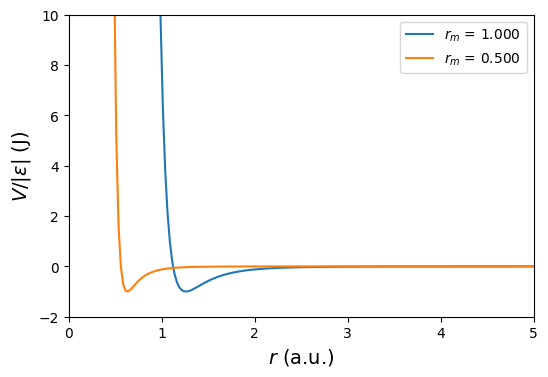

In [128]:
# choose the minimum energy interatomic distances
rmin1 = 1
rmin2 = 0.5

# calculate zero-energy distance
s1 = 2**(1/6) * rmin1
s2 = 2**(1/6) * rmin2

r = np.linspace(0.01, 5, 200) # define a range for r

# calculate the pairwise potential
V1 = 4 * ((s1/r)**12 - (s1/r)**6)
V2 = 4 * ((s2/r)**12 - (s2/r)**6)

fig, ax = plt.subplots(dpi=100)
ax.plot(r, V1)
ax.plot(r, V2)
ax.set_ylim([-2, 10])
ax.legend([f'$r_m$ = {rmin1:.3f}', f'$r_m$ = {rmin2:.3f}'])
ax.set_xlim([0, 5])
ax.set_xlabel('$r$ (a.u.)', fontsize=14)
ax.set_ylabel('$V/|\\varepsilon|$ (J)', fontsize=14)
plt.show()

In [130]:
# time the calculation
# function is V=A-R where A=R^2

number_of_calculations = 10000000 # computers are pretty fast so we'll need to run it a lot of times

# two sets of randomly generated numbers to keep them the same and avoid including the generation time in the total time
random_s = np.random.default_rng().random(size=number_of_calculations)
random_r = np.random.default_rng().random(size=number_of_calculations)

start = time.time() # get time right now
for i in range(number_of_calculations):
    V =  4 * ((random_s[i]/random_r[i])**12 - (random_s[i]/random_r[i])**6) # calculate A and R separately
end1 = time.time() - start  # get duration

start = time.time()  # get time right now
for i in range(number_of_calculations):
    R = (random_s[i]/random_r[i])**6 # calculate R
    V =  4 * (R*R - R) # calculate A from R
end2 = time.time() - start # get duration

print(f'Calculating both A and R: {end1:.3f}')
print(f'Calculating only A: {end2:.3f}')

Calculating both A and R: 17.001
Calculating only A: 11.922


## Timing results
The results I get show that calculating them both takes 1.426 times as long than not. The ratio won't be constant for every system or set of numbers. It may seem like an inconsequential difference but sometimes we need to perform many millions of calculations for hundreds or thousands of particles;  a 100 hour simulation would balloon to 143 hours. 

# Molecular dynamics
Let's simulate some charged spheres and have them interact by Coulombic forces. We'll ignore their masses and sizes, but give them random positions in a 2D box and a random charge in -\[-1, 1\]. We'll set up our random numbers ahead of time for consistent results. We'll also define a function to easily calculate the force between two particles given their index in the arrays.

In [132]:
# Simulation parameters
side_length = 8
time_step = 0.1
total_time = 1
n = 2 # number of particles
seed_position = np.random.SeedSequence().entropy
particle_position = np.random.default_rng(seed=seed_position).random(size=(n,2))*(side_length-2)+1 # x/y positions for each particle
seed_velocity = np.random.SeedSequence().entropy
particle_velocity = (np.random.default_rng(seed=seed_velocity).random(size=(n,2))*2-1) # initial x/y velocities for each particle
seed_charge = np.random.SeedSequence().entropy
charge = np.random.default_rng(seed=seed_charge).random(size=n)*2 - 1 # make the charge random on (-1,1) to make it interesting
print(f'Box side_length: {side_length} units\nParticles in box: {n}\nPosition seed: {seed_position}\nVelocity seed: {seed_velocity}\nCharge seed: {seed_charge}')

def calc_force(id1, id2):
    r2 = (particle_position[id1,:] - particle_position[id2,:])**2
    f = 2*np.abs(charge[id1]*charge[id2])
    return f

Box side_length: 8 units
Particles in box: 2
Position seed: 154308632154959149141453673558489085917
Velocity seed: 337079385595971026516170185188371643854
Charge seed: 53423624536171464772912443100701930519


## Check initialization
Let's see how they look at first. Feel free to re-run the cell above if you'd prefer different starting conditions.

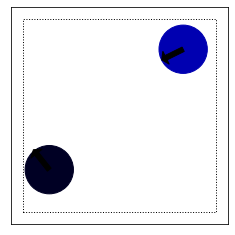

In [133]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.plot()
ax.set_xlim((-.5, side_length+.5))
ax.set_ylim((-.5, side_length+.5))
area = Rectangle((0,0), side_length, side_length, facecolor='none', edgecolor='k', linestyle=':')
ax.add_patch(area)
for p in range(n):
    color = [0,0,-charge[p]] if charge[p] < 0 else [charge[p],0,0]
    circ = Circle(particle_position[p], radius=1, color=color)
    ax.add_patch(circ)
    arrow = Arrow(particle_position[p,0], particle_position[p,1], particle_velocity[p,0], particle_velocity[p,1], color='k')
    ax.add_patch(arrow)
ax.set_yticks([])
ax.set_xticks([])
plt.show()

## Advance by a time step
Every time this cell is executed, the simulation will advance by one time step. It will display the particles and their velocities at that time step. If a particle bumps into a side it will be reflected from that side at the same speed it comes in with.

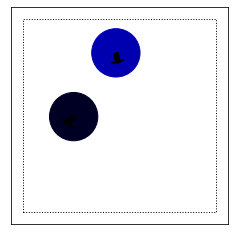

In [211]:
# after one time step
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

ax.plot()
ax.set_xlim((-.5, side_length+.5))
ax.set_ylim((-.5, side_length+.5))
area = Rectangle((0,0), side_length, side_length, facecolor='none', edgecolor='k', linestyle=':')
ax.add_patch(area)
# Update positions
for p in range(n):
    particle_position[p,:] += particle_velocity[p,:] * time_step
    if particle_position[p,0] < 0+1:
        particle_position[p,0] = 0+1
        particle_velocity[p,0] *= -1
    if particle_position[p,1] < 0+1:
        particle_position[p,1] = 0+1
        particle_velocity[p,1] *= -1
    if particle_position[p,0] > side_length-1:
        particle_position[p,0] = side_length-1
        particle_velocity[p,0] *= -1
    if particle_position[p,1] > side_length-1:
        particle_position[p,1] = side_length-1
        particle_velocity[p,1] *= -1
    particle_position[p,:] = particle_position[p,:] % side_length
# Update velocity
for p1 in range(n):
    # calculate forces
    f = 0
    for p2 in range(n):
        if p1 != p2:
            f = calc_force(p1, p2)
            if (charge[p1] < 0 and charge[p2] < 0) or (charge[p1] > 0 and charge[p2] > 0):
                particle_velocity[p1,:] -= f * (particle_position[p2,:] - particle_position[p1,:]) / np.sqrt(np.sum((particle_position[p2,:] - particle_position[p1,:])**2)) * time_step
            else:
                particle_velocity[p1,:] += f * (particle_position[p2,:] - particle_position[p1,:]) / np.sqrt(np.sum((particle_position[p2,:] - particle_position[p1,:])**2)) * time_step
    
for p in range(n):
    color = [0,0,-charge[p]] if charge[p] < 0 else [charge[p],0,0]
    circ = Circle(particle_position[p], radius=1, color=color)
    ax.add_patch(circ)
    arrow = Arrow(particle_position[p,0], particle_position[p,1], particle_velocity[p,0], particle_velocity[p,1], color='k')
    ax.add_patch(arrow)
ax.set_yticks([])
ax.set_xticks([])
plt.show()

## Issues
Our timestep is relatively large but it still takes a good amount of time for anything interesting to occur. It also causes us to skip over a lot of intermediate velocities between timestamps, only taking snapshots during movement.

This simulation is simple and the particles accelerate so quickly past each other that they tend to oscillate. Try to prevent oppositely charged particles from flying past each other. Hint: <code>calc_force</code> implements a totally attractive or repulsive force.